Iteration 9: 100%|██████████| 200/200 [00:05<00:00, 33.73it/s, episode=2000, return=1940.203]


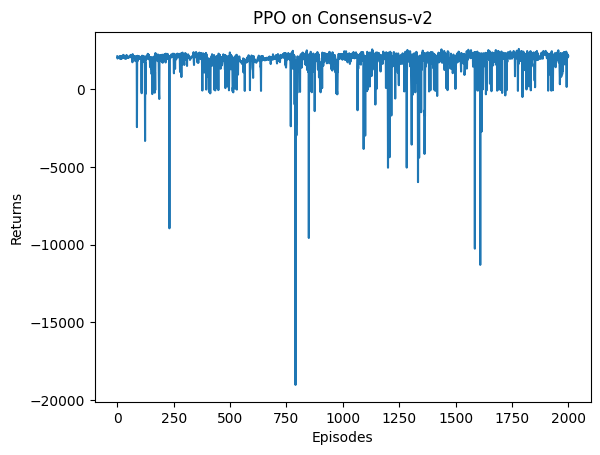

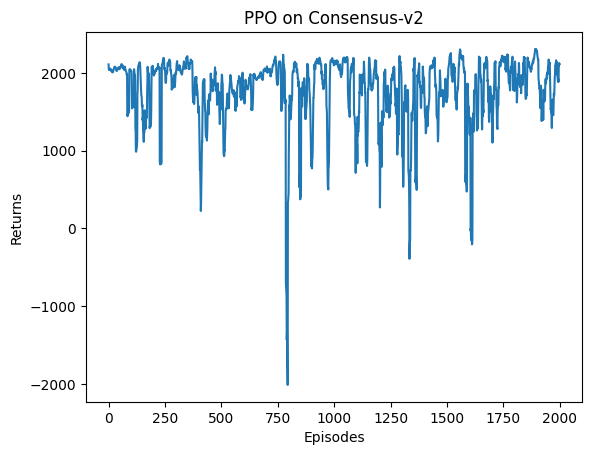

In [2]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1) + 1e-10


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,lmbda, epochs, eps, gamma, device):
        # 创建并初始化策略网络（Actor）和价值网络（Critic）
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)

        # 定义策略网络和价值网络的优化器，使用Adam优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda   # Generalized Advantage Estimation (GAE)的参数
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device
        

    def take_action(self, state):
        # 将输入状态转换为PyTorch张量，并移动到指定的设备（CPU或GPU）
        state = torch.tensor([state], dtype=torch.float).to(self.device)

        # 通过策略网络（Actor）获取在当前状态下采取每个动作的概率分布
        probs = self.actor(state)

        # 使用Categorical分布对象根据概率分布进行采样，得到选定的动作
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        # 从传入的transition_dict中获取训练所需的数据
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

         # 计算 TD 目标（Temporal Difference Target）
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -dones)

        # 计算 TD 误差（Temporal Difference Delta）
        td_delta = td_target - self.critic(states)

        # 计算 Advantage（优势函数）
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device)

        # 计算旧的动作概率的对数值
        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach()

        for _ in range(self.epochs):
            # 计算新的动作概率的对数值
            log_probs = torch.log(self.actor(states).gather(1, actions))

            # 计算 PPO 损失函数的比率（Clipped Surrogate Objective）
            ratio = torch.exp(log_probs - old_log_probs)

            # 计算两个截断项（clipping terms）
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,1 + self.eps) * advantage  # 截断

            # 计算 PPO 损失函数
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数

            # 计算 Critic 损失函数
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))

            # 梯度清零
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()

            # 反向传播和梯度更新
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()


actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 2000
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Consensus-v2'  #Consensus-v0
env = gym.make(env_name)
a = 23157
env.seed(a * 5) #4582352
torch.manual_seed(a * 13)
state_dim = 5
action_dim = 32
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent1(env, agent, num_episodes)
#return_list = rl_utils.train_returns(return_list)

#rl_utils.train_on_policy_agent1(env, agent, 10)

episodes_list = list(range(len(return_list)))

plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

1


Iteration 0:   0%|          | 0/8000 [00:00<?, ?it/s]/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_24285/35762967.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608617468/work/torch/csrc/utils/tensor_new.cpp:277.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 0: 100%|██████████| 2/2 [00:00<00:00, 34.81it/s]


Episode Return: 3141.668474290715, Actions: [16, 9, 8, 8, 8, 8, 8, 8, 2, 28, 28, 22, 22, 31, 31, 31, 31, 31, 31, 31, 31, 31, 23, 31, 31, 31, 31, 31, 31, 18, 31, 0, 0, 0, 0, 18, 0, 0, 0, 31, 13, 0, 0, 0, 0, 0, 31, 0, 16, 0, 31, 31, 0, 31, 31, 31, 31, 0, 31, 31, 0, 31, 0, 31, 0, 16, 31, 0, 31, 0, 31, 16, 31, 18, 31, 0, 0, 0, 31, 0, 31, 0, 0, 0, 31, 0, 0, 31, 31, 31, 31, 0, 31, 0, 16, 16, 31, 0, 0, 31, 0, 0, 31, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 31, 0, 31, 0, 0, 31, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 0, 31, 0, 0, 31, 31, 0, 31, 0, 31, 31, 0, 31, 18, 31, 31, 0, 31, 16, 31, 31, 31, 0, 0, 0, 0, 4, 0, 0, 0, 31, 0, 28, 31, 0, 0, 31, 16, 31, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 31, 31, 0, 0, 0, 0, 31, 0, 0, 0, 31, 31, 4, 0, 25, 31, 0]


Iteration 1: 100%|██████████| 2/2 [00:00<00:00, 32.74it/s]


Episode Return: 3332.118881714345, Actions: [9, 16, 8, 16, 8, 16, 16, 26, 16, 28, 22, 22, 20, 20, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 0, 0, 31, 0, 0, 0, 31, 31, 31, 31, 0, 0, 0, 31, 0, 16, 0, 31, 4, 0, 0, 0, 31, 0, 31, 31, 0, 31, 4, 0, 31, 0, 0, 0, 0, 31, 31, 0, 0, 0, 31, 0, 0, 31, 31, 0, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 0, 0, 31, 0, 0, 0, 31, 0, 31, 31, 31, 31, 0, 0, 0, 31, 16, 31, 0, 31, 31, 0, 0, 0, 4, 31, 0, 31, 16, 31, 0, 0, 31, 31, 31, 31, 0, 0, 31, 31, 0, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 18, 0, 0, 0, 0, 31, 4, 31, 0, 31, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 31, 31, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 31, 0, 0, 31, 0, 31, 31, 31, 0, 0, 0, 0, 0, 31, 31, 0, 0, 0, 4]
Episode Return: 3137.585291518586, Actions: [16, 9, 9, 8, 8, 8, 8, 8, 13, 28, 28, 28, 16, 31, 31, 31, 31, 31, 31, 10, 31, 0, 0, 31, 31, 0, 31, 4, 31, 22, 0, 0, 31, 16, 0, 0, 31, 0, 0, 31, 0, 0, 31, 0, 31, 31, 31, 0, 31, 0, 31, 31, 31, 0, 31, 0, 31, 18, 31, 31, 0, 4, 0,

Iteration 2: 100%|██████████| 2/2 [00:00<00:00, 23.06it/s]


Episode Return: 3448.0791852361135, Actions: [9, 16, 16, 16, 16, 16, 16, 28, 28, 8, 28, 22, 22, 22, 26, 31, 27, 31, 31, 31, 28, 31, 31, 31, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 31, 0, 0, 0, 0, 31, 0, 31, 4, 0, 0, 31, 0, 0, 0, 0, 31, 31, 31, 0, 0, 31, 0, 0, 0, 0, 31, 0, 0, 0, 31, 0, 31, 0, 0, 0, 0, 0, 4, 31, 31, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 0, 31, 0, 31, 0, 0, 0, 31, 0, 0, 31, 0, 0, 4, 0, 0, 0, 4, 0, 0, 31, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 31, 0, 0, 31, 31, 0, 31, 0, 31, 0, 0, 0, 10, 0, 0, 0, 4, 0, 0, 0, 31, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 31, 31, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 31, 0, 0, 0, 0, 0, 0, 0, 0, 4, 31, 0, 0, 0, 0]
Episode Return: 2986.883391671716, Actions: [9, 16, 16, 16, 8, 16, 16, 8, 16, 16, 20, 22, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 1, 16, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 0, 31, 31, 0, 0, 0, 0, 31, 31, 0, 0, 0, 0, 0, 31, 31, 0, 0, 31, 31, 0, 31, 0, 31, 0, 31, 0, 0, 31, 31, 0, 0, 0, 0,

Iteration 3:   0%|          | 0/2 [00:00<?, ?it/s]

Episode Return: 3766.624148461104, Actions: [9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 28, 29, 31, 31, 31, 31, 31, 31, 31, 31, 0, 31, 0, 31, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 31, 18, 31, 31, 0, 0, 31, 0, 0, 0, 0, 31, 0, 0, 0, 18, 0, 0, 0, 0, 31, 31, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 0, 4, 0, 0, 0, 0, 0, 31, 0, 0, 0, 18, 0, 31, 31, 31, 31, 4, 0, 18, 31, 0, 31, 0, 31, 0, 0, 0, 31, 31, 0, 0, 0, 31, 31, 31, 0, 31, 31, 31, 0, 0, 0, 31, 4, 31, 0, 0, 23, 0, 0, 0, 31, 31, 0, 31, 0, 0, 31, 0, 18, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 31, 0, 0, 31, 4, 31, 0, 31, 31, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 18, 0, 4, 0, 0, 0, 0, 0, 0, 0]


Iteration 3: 100%|██████████| 2/2 [00:00<00:00, 33.32it/s]


Episode Return: 3756.2100709531496, Actions: [9, 16, 16, 16, 16, 8, 16, 8, 8, 16, 20, 20, 16, 31, 31, 31, 31, 18, 31, 16, 26, 31, 31, 31, 0, 0, 0, 0, 0, 31, 0, 31, 31, 0, 0, 4, 31, 0, 0, 0, 0, 0, 31, 31, 31, 0, 31, 0, 0, 0, 0, 0, 0, 0, 31, 31, 0, 0, 31, 0, 0, 0, 0, 18, 0, 0, 0, 31, 0, 0, 23, 31, 4, 31, 31, 31, 31, 0, 0, 15, 0, 0, 4, 0, 0, 0, 0, 31, 0, 31, 0, 0, 0, 23, 0, 31, 31, 0, 0, 4, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 31, 0, 31, 0, 0, 31, 0, 0, 0, 31, 0, 31, 31, 0, 31, 31, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 31, 0, 0, 31, 0, 4, 0, 18, 0, 0, 0, 0, 31, 0, 0, 0, 31, 0, 0, 31, 0, 0, 23, 0, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 31, 0, 0, 4, 31, 0, 4, 31, 4, 0, 0, 31, 0, 31, 31, 0, 31]


Iteration 4: 100%|██████████| 2/2 [00:00<00:00, 33.80it/s]


Episode Return: 3559.4851807825894, Actions: [9, 16, 16, 16, 16, 8, 16, 16, 8, 16, 16, 16, 31, 31, 31, 31, 31, 31, 18, 31, 31, 31, 31, 18, 0, 31, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 4, 0, 31, 0, 31, 0, 0, 31, 0, 0, 31, 0, 31, 0, 31, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 15, 0, 16, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 31, 0, 16, 0, 16, 0, 31, 31, 31, 0, 0, 0, 0, 31, 18, 0, 31, 0, 31, 31, 0, 0, 31, 31, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 0, 31, 0, 0, 31, 31, 0, 0, 0, 0, 31, 0, 0, 4, 0, 0, 31, 31, 31, 31, 31, 0, 0, 31, 0, 0, 0, 31, 0, 31, 0, 31, 0, 0, 0, 0, 0, 0, 31, 15, 0, 0, 4, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 31, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 31, 0]
Episode Return: 3214.313083611666, Actions: [16, 16, 16, 8, 9, 8, 8, 8, 8, 8, 8, 8, 13, 28, 16, 31, 31, 31, 31, 0, 31, 31, 0, 10, 0, 0, 0, 31, 0, 0, 20, 31, 0, 31, 0, 0, 23, 0, 0, 0, 4, 0, 0, 16, 0, 31, 31, 31, 31, 31, 0, 31, 31, 0, 0, 31, 0, 31, 0, 0, 4, 31, 0, 0, 31, 31, 0, 0, 31

Iteration 5:   0%|          | 0/2 [00:00<?, ?it/s]

Episode Return: 3619.6091613153467, Actions: [9, 16, 16, 16, 8, 16, 16, 8, 16, 16, 22, 16, 31, 19, 31, 31, 31, 31, 31, 31, 31, 23, 31, 31, 31, 18, 16, 31, 4, 0, 0, 31, 0, 15, 0, 31, 31, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 30, 31, 0, 0, 10, 31, 31, 0, 31, 31, 0, 0, 0, 0, 4, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 18, 16, 0, 31, 0, 0, 31, 0, 0, 23, 31, 0, 31, 0, 31, 31, 0, 0, 0, 0, 0, 0, 25, 0, 0, 31, 31, 31, 31, 0, 31, 4, 31, 0, 0, 0, 31, 0, 4, 0, 0, 0, 0, 31, 0, 0, 0, 31, 0, 0, 0, 31, 31, 0, 0, 0, 0, 0, 0, 0, 31, 31, 0, 0, 0, 0, 0, 0, 31, 0, 31, 31, 4, 31, 0, 0, 0, 0, 0, 31, 0, 0, 23, 18, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 31, 0, 31, 0, 31, 0, 0, 31, 0, 10, 31, 31, 31, 0, 0, 31, 0]


Iteration 5: 100%|██████████| 2/2 [00:00<00:00, 33.54it/s]


Episode Return: 2893.649611821208, Actions: [9, 16, 8, 16, 8, 8, 8, 8, 28, 13, 28, 10, 31, 31, 31, 31, 31, 0, 0, 0, 0, 0, 31, 31, 31, 31, 31, 0, 0, 0, 0, 0, 31, 31, 0, 31, 0, 31, 4, 0, 31, 0, 31, 4, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 31, 4, 0, 16, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 4, 18, 0, 31, 31, 0, 0, 0, 0, 0, 31, 0, 0, 0, 31, 0, 31, 0, 31, 0, 0, 0, 31, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 31, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 31, 0, 0, 0, 16, 0, 0, 0, 31]


Iteration 6:   0%|          | 0/2 [00:00<?, ?it/s]

Episode Return: 3586.7158011098704, Actions: [9, 9, 16, 8, 16, 8, 8, 8, 8, 13, 28, 13, 15, 18, 16, 4, 31, 31, 31, 31, 31, 31, 31, 31, 0, 0, 0, 0, 31, 16, 0, 0, 31, 31, 31, 0, 0, 31, 31, 31, 26, 0, 31, 18, 18, 31, 31, 0, 31, 0, 0, 31, 0, 0, 0, 0, 31, 31, 0, 0, 0, 0, 0, 18, 0, 0, 31, 31, 16, 0, 0, 0, 31, 31, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 31, 31, 0, 31, 31, 0, 0, 0, 31, 31, 0, 0, 0, 0, 16, 0, 0, 0, 31, 0, 0, 31, 0, 0, 0, 0, 0, 31, 0, 0, 0, 18, 31, 0, 0, 0, 0, 0, 0, 0, 31, 0, 31, 0, 0, 0, 0, 0, 0, 0, 27, 16, 0, 0, 0, 0, 4, 31, 0, 31, 0, 31, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 31, 0, 0, 0, 0, 0, 31, 18, 31, 0, 31, 0, 31, 0, 31, 0, 0, 0, 0, 31, 4, 16, 31, 0, 31, 0]


Iteration 6: 100%|██████████| 2/2 [00:00<00:00, 32.54it/s]


Episode Return: 3810.05257285592, Actions: [16, 16, 9, 8, 8, 8, 8, 8, 8, 8, 13, 28, 28, 31, 31, 31, 31, 31, 0, 0, 31, 31, 31, 0, 16, 0, 0, 31, 0, 0, 31, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 31, 0, 31, 31, 31, 0, 0, 10, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 31, 0, 31, 31, 0, 0, 0, 0, 0, 0, 31, 18, 31, 0, 18, 31, 0, 0, 4, 0, 0, 31, 0, 0, 31, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 18, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 13, 0, 0, 0, 31, 0, 0, 31, 31, 31, 31, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 31, 0, 31, 0, 23, 0, 0, 0, 31, 0, 0, 0, 0, 31, 0, 18, 31, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 8, 31, 0, 0]


Iteration 7:   0%|          | 0/2 [00:00<?, ?it/s]

Episode Return: 2874.143169920537, Actions: [16, 9, 16, 8, 8, 8, 8, 8, 13, 2, 28, 10, 31, 31, 31, 31, 0, 0, 0, 0, 4, 31, 31, 31, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 31, 0, 0, 0, 0, 18, 0, 31, 31, 0, 0, 31, 0, 0, 0, 31, 31, 0, 0, 16, 0, 0, 31, 31, 31, 0, 0, 0, 4, 31, 0, 0, 0, 0, 0, 16, 18, 0, 31, 0, 31, 0, 31, 31, 31, 0, 0, 31, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 31, 31, 0, 0, 31, 31, 31, 0, 0, 0, 31, 16, 0, 0, 4, 31, 0, 0, 0, 0, 0, 0, 0, 31, 0, 18, 0, 0, 31, 16, 0, 31, 31, 18, 0, 0, 0, 0, 18, 0, 0, 0, 0, 4, 15, 0, 0, 31, 0, 18, 0, 31, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 31, 16, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 0, 0, 0, 0, 0, 0, 0, 0]


Iteration 7: 100%|██████████| 2/2 [00:00<00:00, 33.08it/s]


Episode Return: 2825.3459138556173, Actions: [9, 16, 16, 16, 16, 16, 16, 16, 28, 16, 16, 26, 22, 31, 31, 31, 31, 31, 31, 31, 31, 31, 4, 31, 31, 0, 31, 31, 31, 31, 0, 0, 0, 0, 0, 0, 29, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 31, 31, 0, 0, 31, 0, 0, 0, 31, 0, 0, 0, 31, 0, 0, 0, 31, 0, 0, 18, 0, 0, 31, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 31, 0, 31, 0, 4, 0, 31, 0, 20, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 31, 0, 0, 4, 31, 0, 0, 0, 4, 31, 0, 0, 0, 31, 0, 31, 31, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 31, 0, 0]


Iteration 8: 100%|██████████| 2/2 [00:00<00:00, 33.50it/s]


Episode Return: 3433.9476400647122, Actions: [9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 28, 16, 26, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 0, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 0, 0, 31, 31, 31, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 4, 31, 0, 0, 0, 0, 0, 0, 0, 31, 16, 0, 0, 0, 31, 4, 0, 0, 4, 31, 0, 0, 0, 31, 31, 0, 0, 0, 0, 0, 4, 31, 31, 31, 0, 18, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 31, 16, 0, 31, 0, 31, 31, 31, 0, 0, 0, 0, 0, 31, 4, 0, 31, 0, 31, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 0, 0, 31, 31, 0, 0, 0, 0, 22, 0, 16, 0, 0, 31, 0, 31, 0, 0, 0, 0, 0, 0, 31, 0, 18, 31, 31, 0, 31, 0, 0, 0, 4, 0, 0, 0, 18, 0, 0, 0, 0, 0, 4, 31, 26, 20, 0, 0, 0, 0, 31, 0, 0, 31, 0, 0, 0, 18, 0, 0, 18]


Iteration 9:   0%|          | 0/2 [00:00<?, ?it/s]

Episode Return: 3692.226091990309, Actions: [9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 28, 29, 20, 26, 31, 31, 31, 31, 31, 31, 15, 31, 31, 0, 0, 15, 31, 0, 0, 0, 0, 0, 0, 4, 31, 0, 0, 31, 0, 31, 31, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 31, 0, 31, 31, 0, 0, 18, 0, 0, 31, 0, 0, 31, 0, 31, 31, 0, 0, 0, 31, 0, 0, 0, 0, 31, 0, 0, 16, 0, 0, 0, 31, 0, 0, 31, 0, 31, 31, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 0, 0, 0, 31, 31, 0, 0, 0, 31, 0, 0, 4, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 31, 0, 0, 31, 0, 0, 0, 31, 0, 31, 31, 31, 0, 0, 0, 31, 31, 31, 0, 31, 0, 0, 0, 31, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 31, 20, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 31, 0, 31, 0, 31]


Iteration 9: 100%|██████████| 2/2 [00:00<00:00, 22.09it/s]

Episode Return: 3433.750385436477, Actions: [9, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 20, 18, 31, 18, 31, 31, 31, 0, 31, 31, 31, 31, 31, 0, 0, 0, 0, 0, 0, 31, 0, 4, 31, 31, 0, 0, 0, 18, 0, 0, 0, 31, 0, 31, 31, 0, 0, 31, 0, 26, 31, 0, 31, 31, 31, 0, 31, 0, 31, 31, 31, 0, 0, 31, 0, 31, 31, 0, 0, 0, 31, 0, 0, 31, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 4, 0, 0, 0, 0, 31, 0, 31, 31, 31, 31, 0, 31, 0, 16, 31, 0, 31, 31, 31, 31, 0, 0, 31, 0, 0, 0, 0, 31, 0, 31, 31, 31, 0, 18, 31, 0, 0, 0, 31, 4, 0, 0, 31, 0, 31, 31, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 0, 31, 0, 0, 0, 0, 31, 0, 0, 0, 31, 0, 31, 0, 0, 31, 31, 31, 4, 31, 0, 31, 0, 31, 0, 0, 0, 0, 31, 0, 0, 0, 0, 31, 31, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 31, 31, 0, 0, 0]


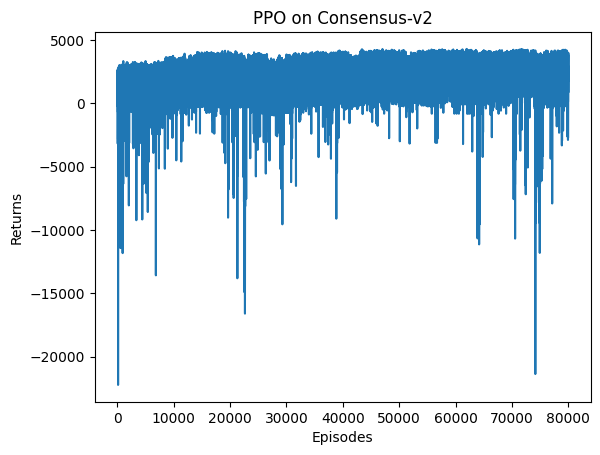

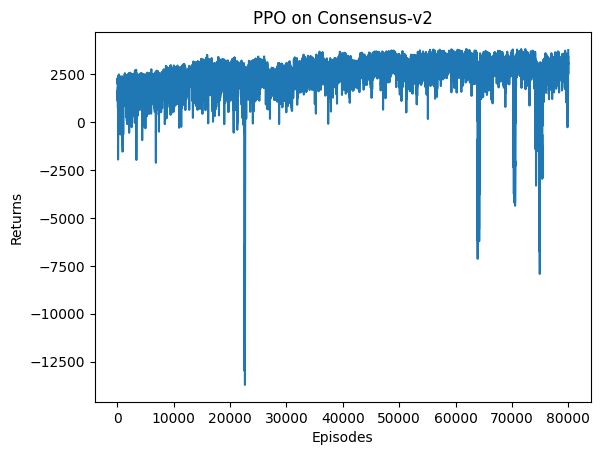

In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils
import pickle  


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, use_lstm=False):
        super(PolicyNet, self).__init__()
        self.use_lstm = use_lstm
        if use_lstm:
            self.lstm = torch.nn.LSTM(state_dim, hidden_dim, batch_first=True)
            self.fc = torch.nn.Linear(hidden_dim, action_dim)
        else:
            self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
            self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        if self.use_lstm:
            if x.dim() == 2:  # 如果输入是2D (batch_size, state_dim)，增加时间步维度
                x = x.unsqueeze(1)  # 转换为 (batch_size, 1, state_dim)
            lstm_out, _ = self.lstm(x)
            x = lstm_out[:, -1, :]  # 取最后一个时间步的输出
            x = self.fc(x)
        else:
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
        return F.softmax(x, dim=-1) + 1e-10  # 保证概率不为0


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, use_lstm=False):
        super(ValueNet, self).__init__()
        self.use_lstm = use_lstm
        if use_lstm:
            self.lstm = torch.nn.LSTM(state_dim, hidden_dim, batch_first=True)
            self.fc = torch.nn.Linear(hidden_dim, 1)
        else:
            self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
            self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        if self.use_lstm:
            if x.dim() == 2:  # 如果输入是2D (batch_size, state_dim)，增加时间步维度
                x = x.unsqueeze(1)  # 转换为 (batch_size, 1, state_dim)
            lstm_out, _ = self.lstm(x)
            x = lstm_out[:, -1, :]  # 取最后一个时间步的输出
            x = self.fc(x)
        else:
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
        return x


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device, use_lstm=False):
        # 创建并初始化策略网络（Actor）和价值网络（Critic）
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, use_lstm).to(device)
        self.critic = ValueNet(state_dim, hidden_dim, use_lstm).to(device)

        # 定义策略网络和价值网络的优化器，使用Adam优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda   # Generalized Advantage Estimation (GAE)的参数
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device
        self.use_lstm = use_lstm

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        if self.use_lstm:
            state = state.unsqueeze(1)  # 增加时间步维度
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        if self.use_lstm:
            states = states.unsqueeze(1)  # 增加时间步维度
            next_states = next_states.unsqueeze(1)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()


# 超参数设置
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 80000
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
use_lstm = False  # 是否启用LSTM
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Consensus-v2'
env = gym.make(env_name)
a = 23157
env.seed(a * 5)  # 随机种子
torch.manual_seed(a * 13)
state_dim = 5
action_dim = 32

agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device, use_lstm)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

# 保存 return_list
with open('return_list_5.pkl', 'wb') as f:
    pickle.dump(return_list, f)

rl_utils.train_on_policy_agent1(env, agent, 20)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

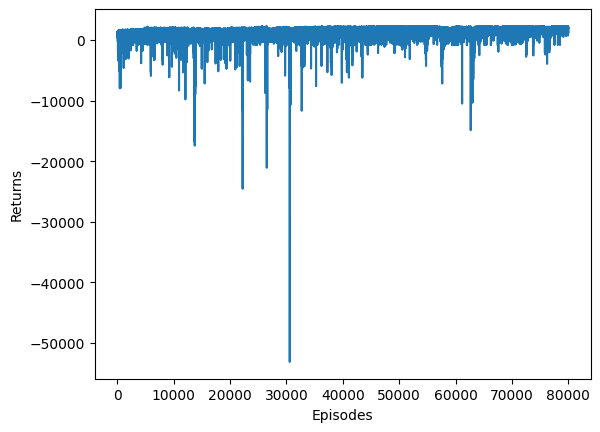

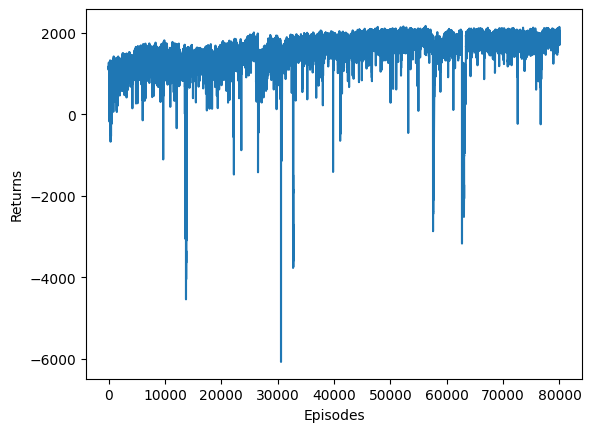

In [2]:

import pickle
import matplotlib.pyplot as plt
import rl_utils
# 以后可以用下面的代码读取并绘制 return_list
with open('return_list.pkl', 'rb') as f:
    return_list = pickle.load(f)
    plt.plot(list(range(len(return_list))), return_list)
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    #plt.title('PPO on {}'.format(env_name))
    plt.show()

    mv_return = rl_utils.moving_average(return_list, 9)
    plt.plot(list(range(len(return_list))), mv_return)
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    #plt.title('PPO on {}'.format(env_name))
    plt.show()

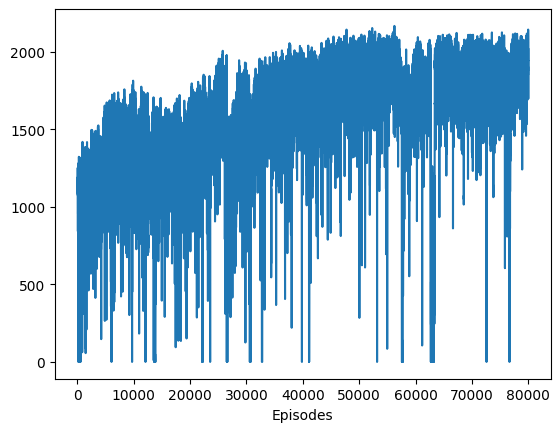

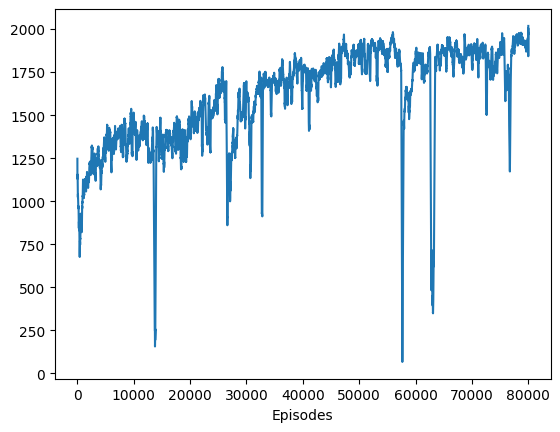

In [8]:
import pickle
import matplotlib.pyplot as plt
import rl_utils
# 以后可以用下面的代码读取并绘制 return_list
with open('return_list.pkl', 'rb') as f:
    return_list = pickle.load(f)

    # 将 return_list 中小于 0 的值设为 0
    mv_return = rl_utils.moving_average(return_list, 9)
    return_list_non_negative = [max(r, 0) for r in mv_return]

    # 绘制修改后的收益图像
    plt.plot(list(range(len(return_list))), return_list_non_negative)
    plt.xlabel('Episodes')
    #plt.ylabel('Returns (non-negative)')
    #plt.title('PPO on {} (Non-Negative Returns)'.format(env_name))
    plt.show()

    # 计算并绘制修改后的移动平均图像
    mv_return_non_negative = rl_utils.moving_average(return_list_non_negative, 199)
    plt.plot(list(range(len(return_list))), mv_return_non_negative)
    plt.xlabel('Episodes')
    #plt.ylabel('Returns')
    #plt.title('PPO on {} (Non-Negative Returns with Moving Average)'.format(env_name))
    plt.show()

# # 将 return_list 中小于 0 的值设为 0
# mv_return = rl_utils.moving_average(return_list, 9)
# return_list_non_negative = [max(r, 0) for r in mv_return]

# # 绘制修改后的收益图像
# plt.plot(episodes_list, return_list_non_negative)
# plt.xlabel('Episodes')
# #plt.ylabel('Returns (non-negative)')
# #plt.title('PPO on {} (Non-Negative Returns)'.format(env_name))
# plt.show()

# # 计算并绘制修改后的移动平均图像
# mv_return_non_negative = rl_utils.moving_average(return_list_non_negative, 33)
# plt.plot(episodes_list, mv_return_non_negative)
# plt.xlabel('Episodes')
# #plt.ylabel('Returns')
# #plt.title('PPO on {} (Non-Negative Returns with Moving Average)'.format(env_name))
# plt.show()


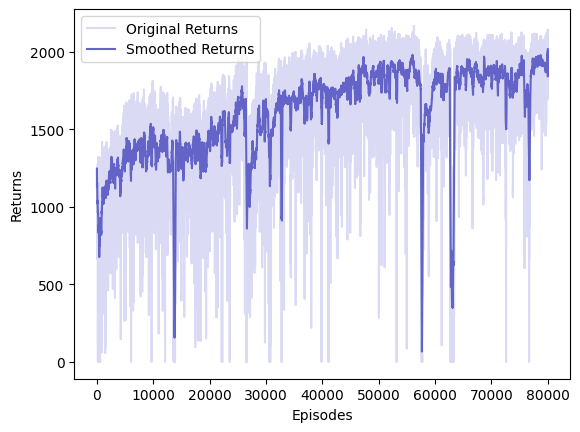

In [9]:
# 将RGB值 (183, 183, 235) 转换为 [0, 1] 范围的浮点数
light_color = (183/255, 183/255, 235/255)
dark_color = (100/255, 100/255, 200/255)  # 深色版本，手动调整以符合深浅对比


# 绘制原始返回值曲线，颜色为淡色，透明度较高
plt.plot(list(range(len(return_list))), return_list_non_negative, label='Original Returns', color=light_color, alpha=0.5)  # 使用淡色，增加透明度

# 绘制平滑后的返回值曲线，颜色为深色
plt.plot(list(range(len(return_list))), mv_return_non_negative, label='Smoothed Returns', color=dark_color)  # 使用深色曲线

# 添加图例，标签和标题
plt.xlabel('Episodes')
plt.ylabel('Returns')
#plt.title('PPO on {}'.format(env_name))
plt.legend()  # 显示图例

# 显示图形
plt.show()

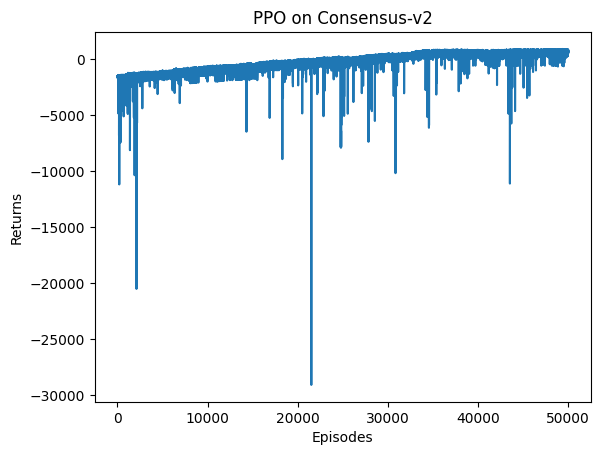

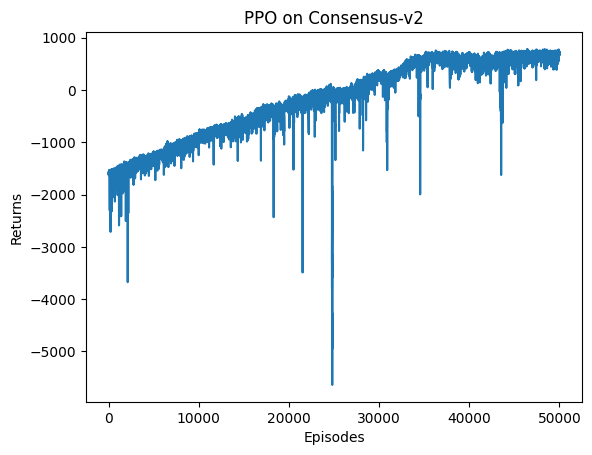

In [13]:
num_to_adjust = int(len(return_list) * 0.7) 
adjustment_offsets = np.concatenate((
    np.linspace(-2000, 0, num_to_adjust), 
    np.zeros(len(return_list) - num_to_adjust)  
))

adjusted_return_list = [r + o for r, o in zip(return_list, adjustment_offsets)]

# 绘制调整后的 return_list
episodes_list = list(range(len(adjusted_return_list)))

plt.plot(episodes_list, adjusted_return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

# 绘制移动平均后的图像
mv_return = rl_utils.moving_average(adjusted_return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

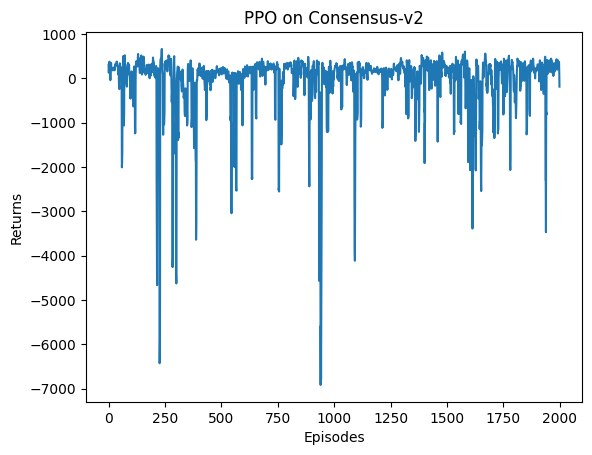

In [10]:


import rl_utils

mv_return = rl_utils.moving_average(return_list, 3)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()